#**Set up files and notebook**

In [ ]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#from mpl_toolkits.basemap import Basemap

In [ ]:
# Authenticate google drive access and mount it to /content/drive path.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Check the contents of the Data/ directory.
import glob
DATA_PATH_PREFIX = '/content/drive/My Drive/Colab Notebooks/Data'
def get_data_file(file_name):
  return DATA_PATH_PREFIX+'/'+file_name 
glob.glob(DATA_PATH_PREFIX + '/*')

In [ ]:
prefix = '/content/drive/My Drive/Colab Notebooks/Data/XContest'
def get_file(file_name):
  return prefix + '/' + file_name
glob.glob(prefix + '/*')

#**Definitions**

In [5]:
def read_data(file):
  xc = pd.read_json(get_file(file), orient='records')
  return xc

def cleanup(data):
  data = data[['pilot', 'pointStart', 'stats', 'takeoff', 'glider']]
  return data

def extract_dict(data, column):
  data_extracted = data[column].apply(pd.Series)
  return data_extracted

def clean_pilot(data):
  data = data[['id', 'username', 'countryIso', 'isMale']]
  data = data.rename(columns={'id':'idPilot', 'countryIso':'fromCountry'})
  return data

def clean_takeoff(data):
  data = data[['name', 'countryIso']]
  data = data.rename(columns={'name':'takeoffName', 'countryIso':'takeoffCountry'})
  return data

def clean_glider(data):
  data = data[['name', 'nameProducer', 'subclass']]
  data = data.rename(columns={'name':'gliderName', 'nameProducer':'gliderProducer', 'subclass':'gliderClass'})
  return data

def clean_pointStart(data):
  data = data.rename(columns={'time':'takeoffTime'})
  return data

def clean_stats(data):
  data = data.rename(columns={'duration':'flightDuration'})
  return data

def combine_frames(data1, data2, original_column):
  final_data = pd.concat([data1, data2], axis=1).drop(original_column, axis=1)
  return final_data

def delete_NO_glider(data):
  data = data[data.gliderProducer.map(len) > 1]
  return data

def order_descending(data, series):
  data = data.sort_values(series, ascending=False)
  return data

def give_month(takeoff):
  s = takeoff[5:7]
  month_to_name = {'01': 1, '02':2, '03': 3, '04':4, 
                   '05':5, '06':6, '07':7, '08':8, '09':9,
                   '10':10, '11':11, '12':12}
  return month_to_name[s]
  
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
          'September', 'October', 'November', 'December']

def get_month_index(month):
  return month-1

def get_country_index(country):
  return country_idx[country]

def clean_time(time):
  time = time[2:4] + ":" + time[5:7] + ":" + time[8:10]
  return time

def date_datetime(column):
  column = pd.to_datetime(column)       #.dt.time
  return column

def find_mistake_time(time):
  if time[6] == "-":
    return False
  else:
    return True

def define_time_categories(time):
  if time[0] != '0' and time[3] in ['0', '1', '2']:
    t = int(time[0:2]) + 0.5
  elif time[0] == '0' and time[3] in ['0', '1', '2']:
    t = int(time[1]) + 0.5
  elif time[0] == '0' and time[3] in ['3', '4', '5']:
    t = int(time[1]) + 0.9
  elif time[0] != '0' and time[3] in ['3', '4', '5']:
    t = int(time[0:2]) + 0.9
  return t

time_categories = ['0:30', '1:00', '1:30', '2:00', '2:30', '3:00', '3:30', '4:00', '4:30', '5:00', '5:30', '6:00', 
                   '6:30', '7:00', '7:30', '8:00', '8:30', '9:00', '9:30', '10:00', '10:30', '11:00']

def make_delta_time(time):
  h, m, s = time.split(':')
  return datetime.timedelta(hours=int(h), minutes=int(m), seconds=int(s))

def round_to_minutes(time):
  return time.round(freq='T')

def return_to_time(number):
  number = pd.TimedeltaIndex(number, unit='m')
  return number

def myplot(graph):
  graph = graph[graph.index < pd.Timedelta(seconds=5*3600)]
  ax = graph.plot(figsize=(25,15)) 
  vals = ax.get_yticks()
  ax.set_yticklabels(['{}%'.format(x) for x in vals])

def get_percents(amount):
  amount = amount / sum(amount)*100
  return amount

#**Read and clean the original data from xc 2019**

In [45]:
xc_2019 = read_data('merged-2019.json.xz')
print(xc_2019.shape)
xc_2019 = cleanup(xc_2019)

(286864, 18)


**Extract and clean the data**

In [ ]:
xc_2019_pilot_extracted = extract_dict(xc_2019, 'pilot')
xc_2019_takeoff_extracted = extract_dict(xc_2019, 'takeoff')
xc_2019_glider_extracted = extract_dict(xc_2019, 'glider')
xc_2019_pointStart_extracted = extract_dict(xc_2019, 'pointStart')
xc_2019_stats_extracted = extract_dict(xc_2019, 'stats')

In [ ]:
xc_2019_pilot_cleaned = clean_pilot(xc_2019_pilot_extracted)
xc_2019_takeoff_cleaned = clean_takeoff(xc_2019_takeoff_extracted)
xc_2019_glider_cleaned = clean_glider(xc_2019_glider_extracted)
xc_2019_pointStart_cleaned = clean_pointStart(xc_2019_pointStart_extracted)
xc_2019_stats_cleaned = clean_stats(xc_2019_stats_extracted)

In [ ]:
xc_2019_cleaned = combine_frames(xc_2019, xc_2019_pilot_cleaned, 'pilot')
xc_2019_cleaned = combine_frames(xc_2019_cleaned, xc_2019_takeoff_cleaned, 'takeoff')
xc_2019_cleaned = combine_frames(xc_2019_cleaned, xc_2019_glider_cleaned, 'glider')
xc_2019_cleaned = combine_frames(xc_2019_cleaned, xc_2019_pointStart_cleaned, 'pointStart')
xc_2019_cleaned = combine_frames(xc_2019_cleaned, xc_2019_stats_cleaned, 'stats')
xc_2019_cleaned = xc_2019_cleaned[xc_2019_cleaned.takeoffTime.notnull()]
xc_2019_cleaned = xc_2019_cleaned.reset_index(drop=True)
xc_2019_cleaned["takeoffMonth"] = xc_2019_cleaned.takeoffTime.map(give_month)
xc_2019_cleaned = xc_2019_cleaned.drop([222421, 265162, 278725])
xc_2019_cleaned.head()


#**Save cleaned data back to drive**

In [ ]:
xc_2019_cleaned.to_json("/content/drive/My Drive/Colab Notebooks/Data/XContest/xc_2019_cleaned.json")


#**Read the cleaned data from drive**

In [ ]:
xc_2019_cleaned = read_data('xc_2019_cleaned.json')
xc_2019_cleaned = xc_2019_cleaned.drop([222421, 265162, 278725, 233031])
#xc_2019_cleaned['Right_time'] = xc_2019_cleaned.flightDuration.map(find_mistake_time) #used to find wrong notation of time, after not needed anymore
#time_wrong = xc_2019_cleaned.loc[xc_2019_cleaned['Right_time'] == False]               #used to find wrong notation of time, after not needed anymore
xc_2019_cleaned.flightDuration = xc_2019_cleaned.flightDuration.map(clean_time)
xc_2019_cleaned.flightDuration = xc_2019_cleaned.flightDuration.map(make_delta_time)
xc_2019_cleaned['TimeCategory'] = xc_2019_cleaned.flightDuration.map(round_to_minutes)

#**Create separate df for men and women - all flights**

**Dataframe - women**

In [20]:
xc_2019_women = xc_2019_cleaned.loc[xc_2019_cleaned['isMale'] == False]
xc_2019_women = xc_2019_women.reset_index(drop=True)
xc_2019_women["takeoffMonth"] = xc_2019_women.takeoffTime.map(give_month)
airtime_sum_women = xc_2019_women.flightDuration.sum()
flights_women = xc_2019_women.shape[0]
airtime_per_flight_women = airtime_sum_women / flights_women
print("Average duration of the woman's flight in 2019:", airtime_per_flight_women)

Average duration of the woman's flight in 2019: 0 days 01:10:05.125034


**Dataframe - men**

In [21]:
xc_2019_men = xc_2019_cleaned.loc[xc_2019_cleaned['isMale']]
xc_2019_men.head()
xc_2019_men = xc_2019_men[xc_2019_men.takeoffTime.notnull()]
xc_2019_men = xc_2019_men.reset_index(drop=True)
xc_2019_men["takeoffMonth"] = xc_2019_men.takeoffTime.map(give_month)
airtime_sum_men = xc_2019_men.flightDuration.sum()
flights_men = xc_2019_men.shape[0]
airtime_per_flight_men = airtime_sum_men / flights_men
print("Average duration of the man's flight in 2019:", airtime_per_flight_men)

Average duration of the man's flight in 2019: 0 days 01:20:10.098556


#**Flights per country per month**

In [23]:
xc_2019_byMonthCountry = xc_2019_cleaned.groupby(by=['takeoffMonth', 'takeoffCountry'])
xc_2019_heatData = xc_2019_byMonthCountry.size().reset_index(name='count')
index = xc_2019_heatData.takeoffCountry.unique()
cols = xc_2019_heatData.takeoffMonth.unique()
data = np.zeros((index.size, cols.size))
country_idx = dict()
for idx, country in enumerate(index):
  country_idx[country] = idx

for _, row in xc_2019_heatData.iterrows():
  month_index = get_month_index(row['takeoffMonth'])
  country_index = get_country_index(row['takeoffCountry'])
  data[country_index, month_index] = row['count']

xc_2019_heatMatrix = pd.DataFrame(data, index=index, columns=cols, )
pd.set_option('display.max_rows', 200)
xc_2019_heatMatrix.style.background_gradient(cmap='Blues')

#**The lenght of flights**

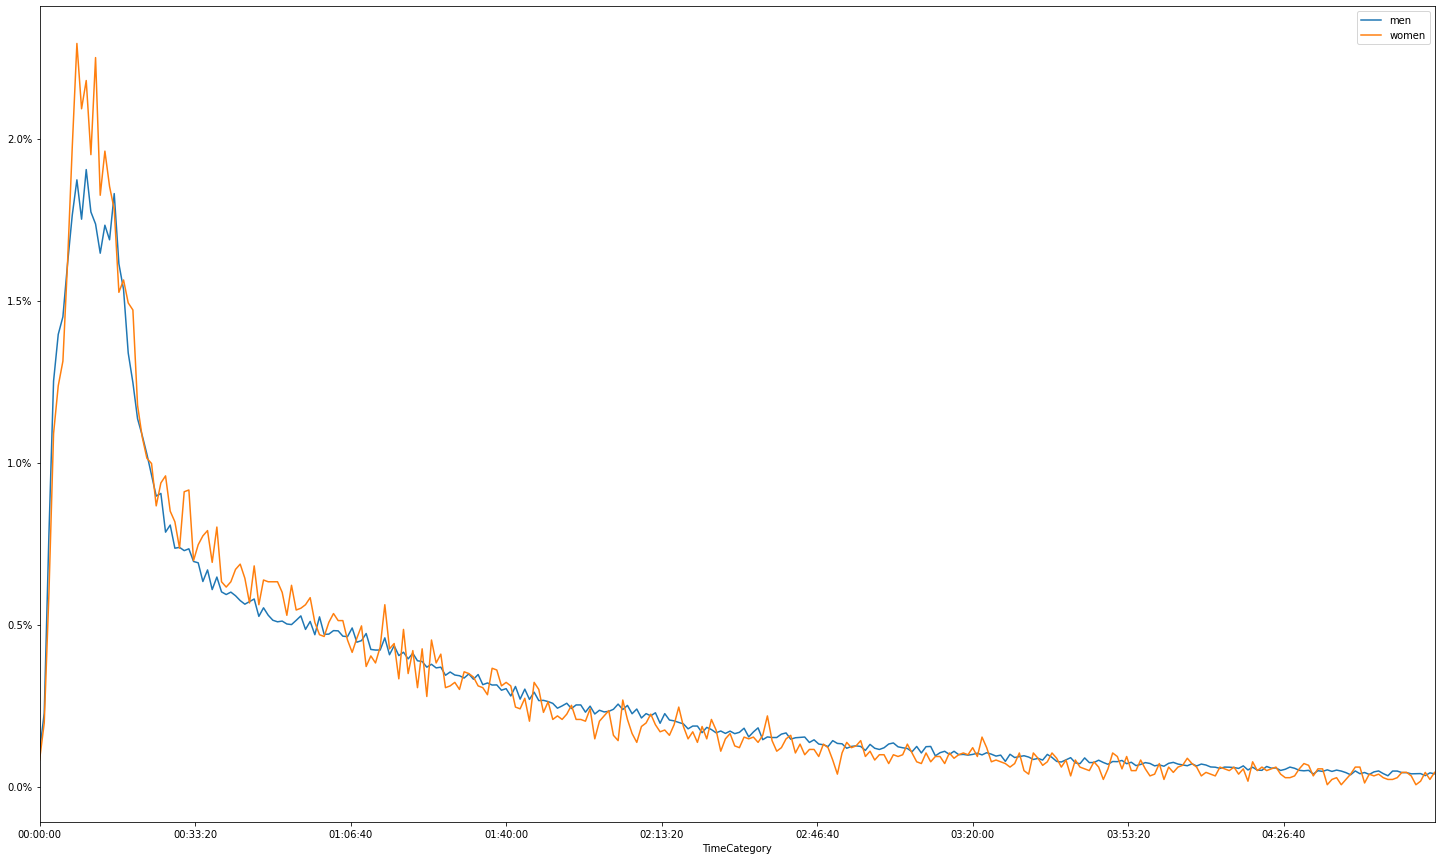

In [25]:
women = xc_2019_women.groupby('TimeCategory').TimeCategory.count()
women = get_percents(women)
men = xc_2019_men.groupby('TimeCategory').TimeCategory.count()
men = get_percents(men)
myplot(pd.concat({'men': men, 'women': women}, axis=1))

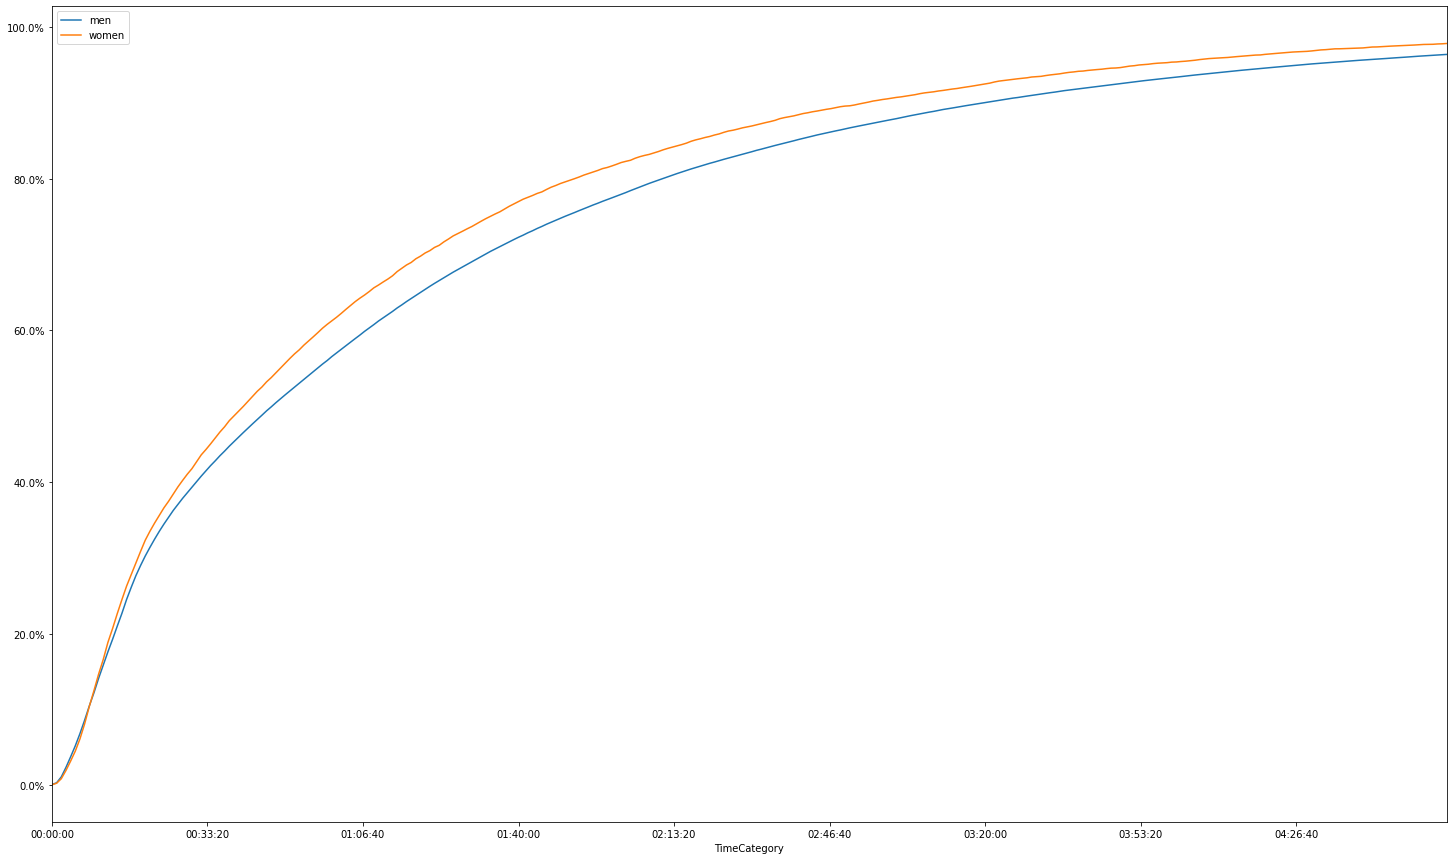

In [26]:
myplot(pd.concat({'men': men.cumsum(), 'women': women.cumsum()}, axis=1))

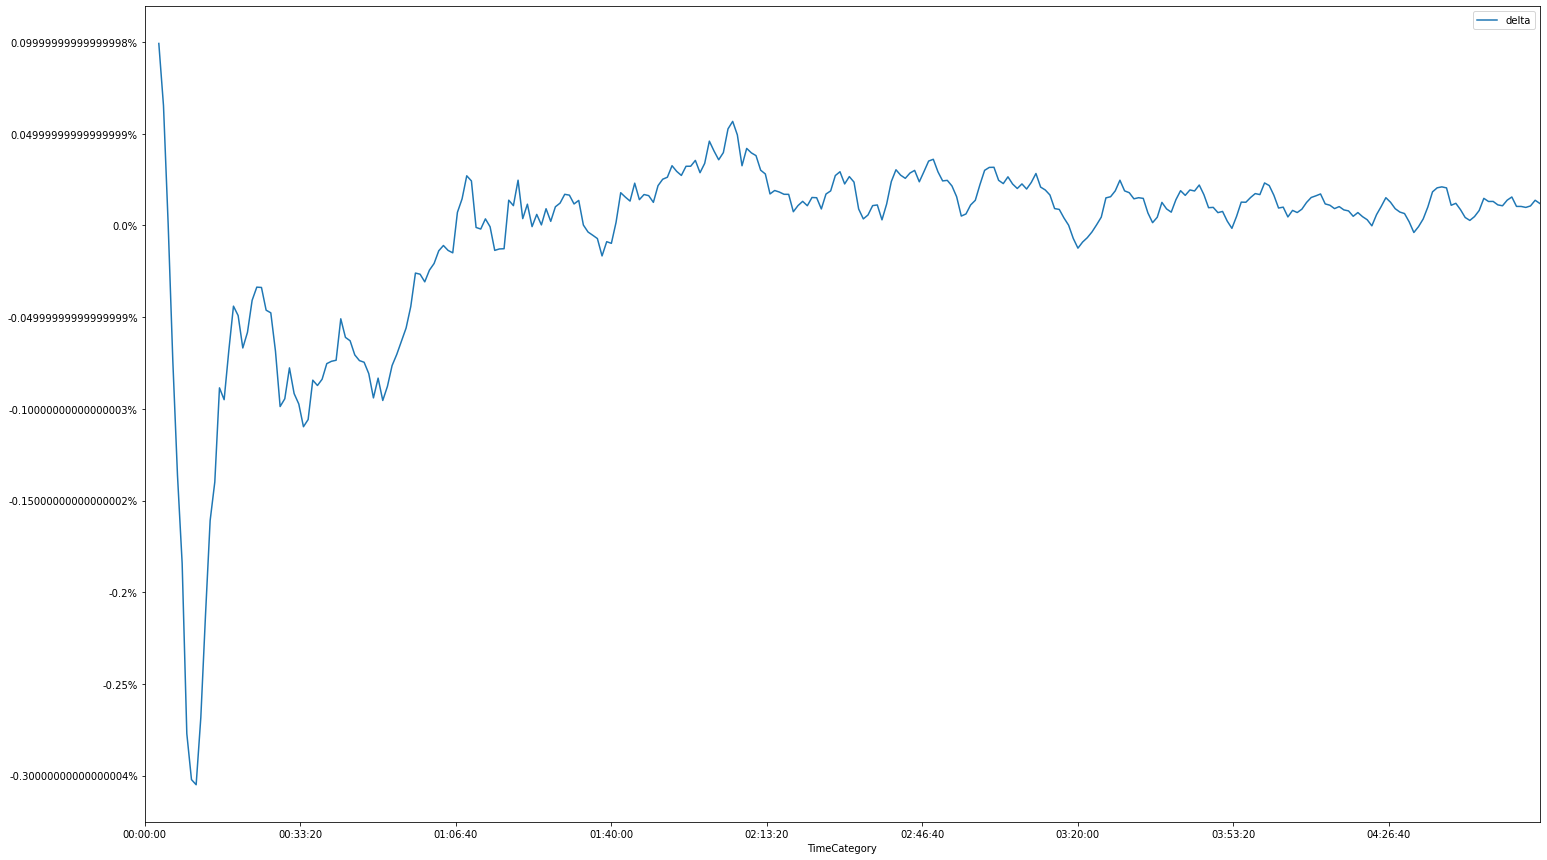

In [27]:
myplot(pd.concat({'delta': (men-women).rolling(window=7, center=True).mean()}, axis=1))

#**Countries with most take offs**

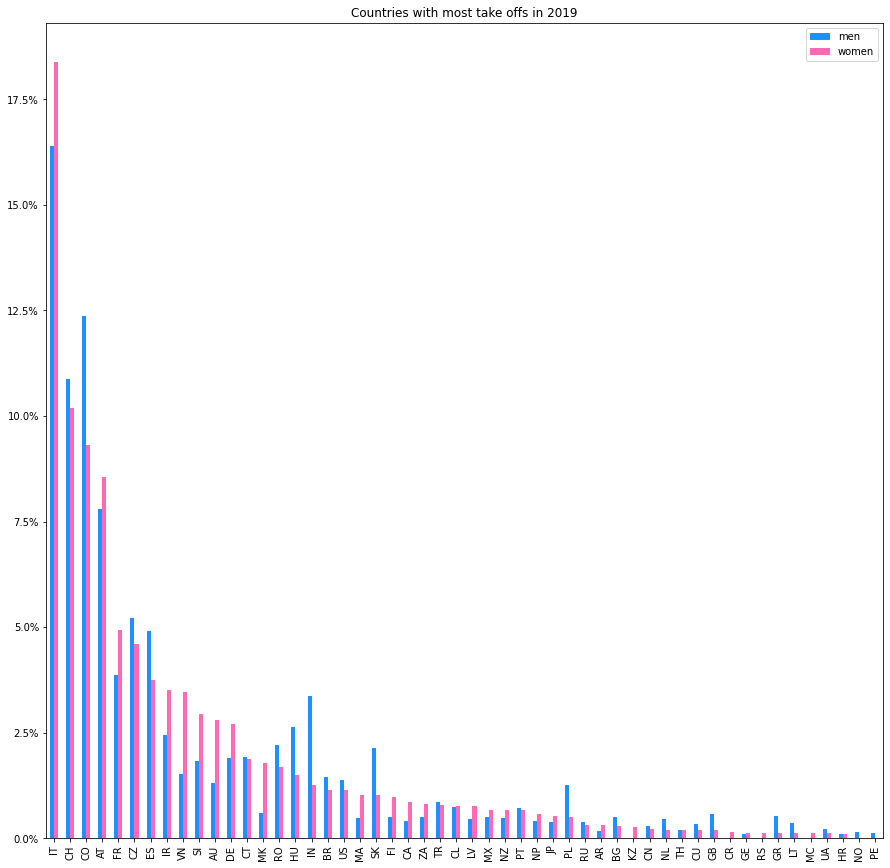

In [29]:
women = xc_2019_women.groupby('takeoffCountry').takeoffCountry.count()
women = get_percents(women)
women = women[women > 0.1]
men = xc_2019_men.groupby('takeoffCountry').takeoffCountry.count()
men = get_percents(men)
men = men[men > 0.1]
graph = pd.concat({'men': men, 'women': women}, axis=1).sort_values('women', ascending=False)
ax = graph.plot.bar(title="Countries with most take offs in 2019", color=['dodgerblue', 'hotpink'], figsize=(15,15))
vals = ax.get_yticks()
ax.set_yticklabels(['{}%'.format(x) for x in vals])
ax

#**Flights based on time of the year**

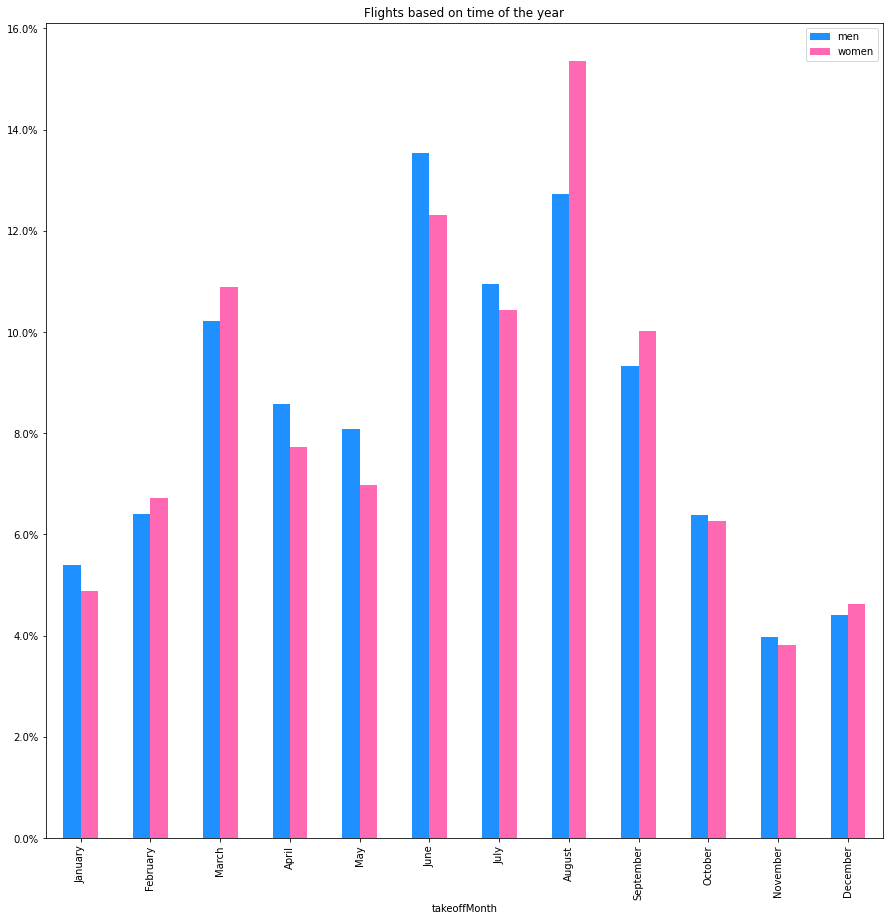

In [12]:
women = xc_2019_women.groupby('takeoffMonth').takeoffMonth.count()
women = get_percents(women)
men = xc_2019_men.groupby('takeoffMonth').takeoffMonth.count()
men = get_percents(men)
graph = pd.concat({'men': men, 'women': women}, axis=1)
ax = graph.plot.bar(title="Flights based on time of the year", color=['dodgerblue', 'hotpink'], figsize=(15,15))
vals = ax.get_yticks()
x_ticks = ax.get_xticks()
ax.set_yticklabels(['{}%'.format(x) for x in vals])
ax.set_xticklabels([months[x] for x in x_ticks])
ax

#**Create df of unique pilots - men and women**

**Creat df of unique pilots based on their longest flight**

In [44]:
women_2019 = order_descending(xc_2019_women, 'flightDuration')
women_2019 = women_2019.drop_duplicates(subset=['idPilot'])
pilots_women = women_2019.shape[0]
men_2019 = order_descending(xc_2019_men, 'flightDuration')
men_2019 = men_2019.drop_duplicates(subset=['idPilot'])
pilots_men = men_2019.shape[0]

**Amount of men and women flying in 2019**

There are 1019 women pilots in 2019.
There are 13951 men pilots in 2019. 



<function matplotlib.pyplot.show>

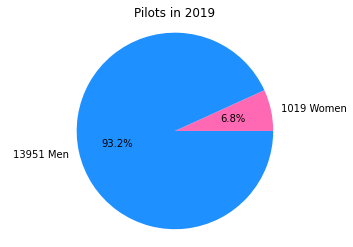

In [42]:
print("There are", pilots_women, "women pilots in 2019.")
print("There are", pilots_men, "men pilots in 2019.", '\n')
pilots = [pilots_women, pilots_men]
labels = [str(pilots_women) + ' Women', str(pilots_men) + ' Men']
plt.pie(pilots, labels=labels, colors=['hotpink', 'dodgerblue'], autopct='%1.1f%%', radius=2.0)
plt.title('Pilots in 2019')
plt.axis('equal')
plt.show

**Average airtime per pilot in a year**

<BarContainer object of 2 artists>

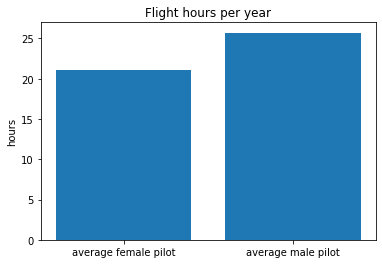

In [14]:
airtime_sum_women = xc_2019_women.flightDuration.sum()
airtime_per_woman = pd.Timedelta(seconds=airtime_sum_women.total_seconds() / pilots_women)
airtime_sum_men = xc_2019_men.flightDuration.sum()
airtime_per_man = pd.Timedelta(seconds=airtime_sum_men.total_seconds() / pilots_men)

airtime = {'female pilot': airtime_per_woman, 'male pilot': airtime_per_man}
average_flying = pd.DataFrame({'average pilots':['average female pilot', 'average male pilot'],
                               'sum airtime':[airtime_per_woman.total_seconds()/3600,
                                              airtime_per_man.total_seconds()/3600]})

plt.title('Flight hours per year')
plt.ylabel('hours')
plt.bar(x=average_flying['average pilots'], height=average_flying['sum airtime'])

#**Glider classes**

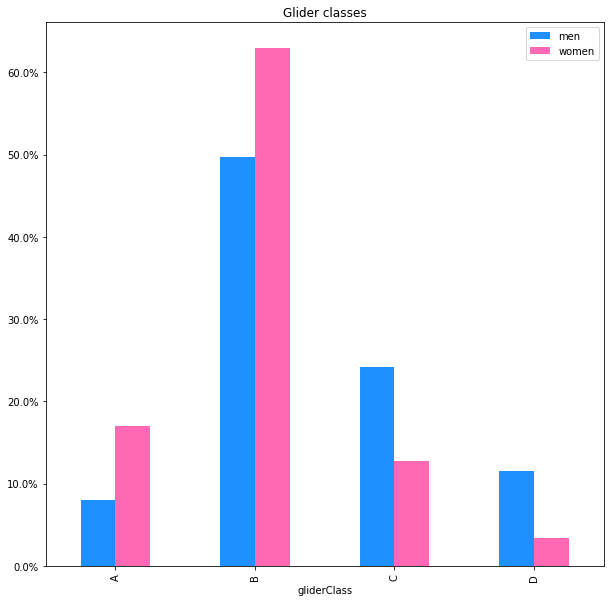

In [16]:
women = women_2019.groupby('gliderClass').gliderClass.count()
women = get_percents(women)
men = men_2019.groupby('gliderClass').gliderClass.count()
men = get_percents(men)
graph = pd.concat({'men': men, 'women': women}, axis=1)
graph = graph.drop(['T', 'Z'])
ax = graph.plot.bar(title="Glider classes", color=['dodgerblue', 'hotpink'], figsize=(10,10))
vals = ax.get_yticks()
ax.set_yticklabels(['{}%'.format(x) for x in vals])
ax

#**Brands of gliders**

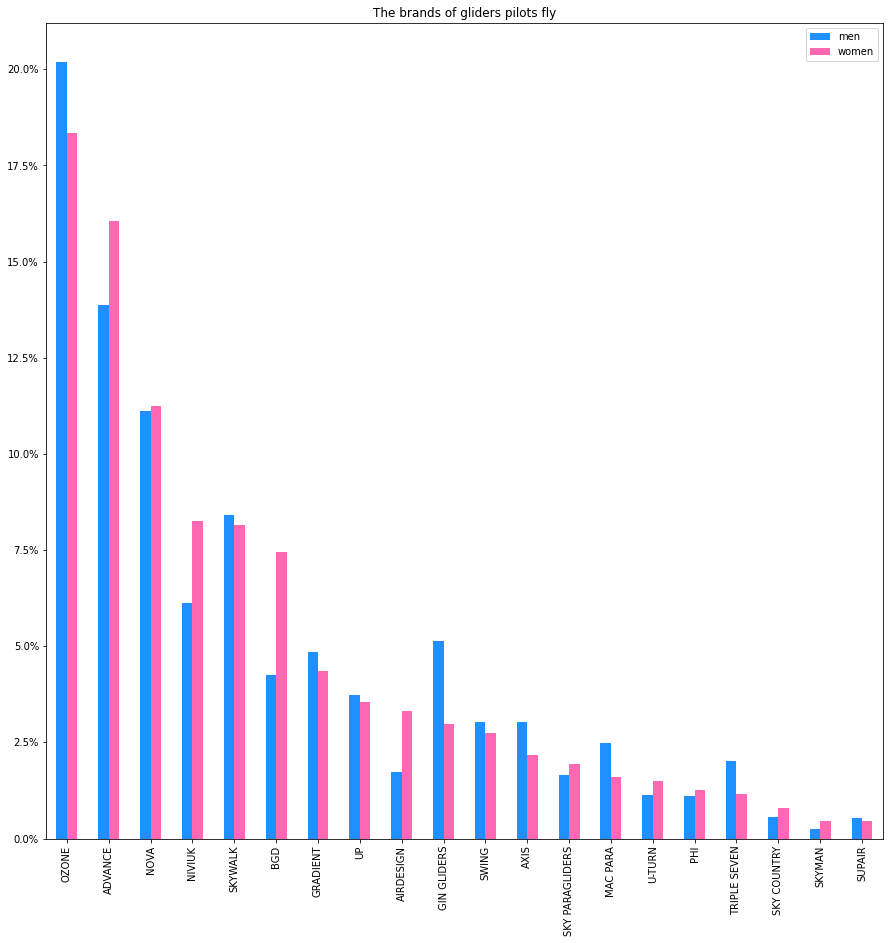

In [17]:
women = delete_NO_glider(women_2019)
women = women.groupby('gliderProducer').gliderProducer.count()
women = get_percents(women)
women = women[women > 0.1]
men = delete_NO_glider(men_2019)
men = men.groupby('gliderProducer').gliderProducer.count()
men = get_percents(men)
men = men[men > 0.1]
graph = pd.concat({'men': men, 'women': women}, axis=1).sort_values('women', ascending=False)
graph = graph[:20]
ax = graph.plot.bar(title="The brands of gliders pilots fly", color=['dodgerblue', 'hotpink'], figsize=(15,15))
vals = ax.get_yticks()
ax.set_yticklabels(['{}%'.format(x) for x in vals])
ax

#**Where are the pilots from**

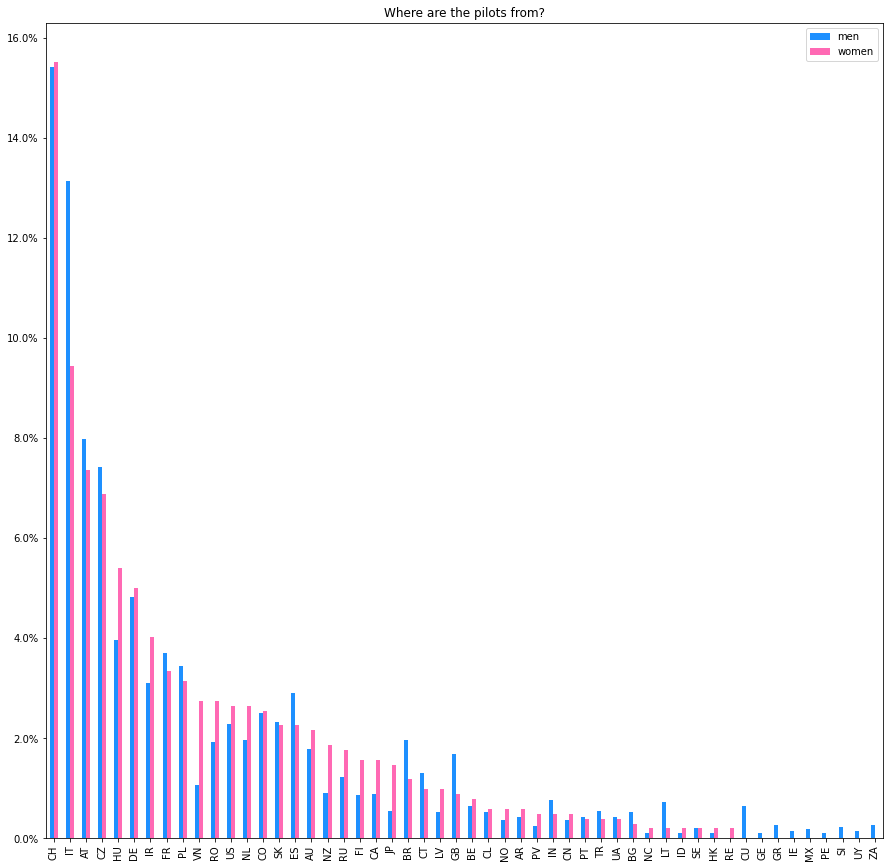

In [18]:
women = women_2019.groupby('fromCountry').fromCountry.count()
women = get_percents(women)
women = women[women > 0.1]
men = men_2019.groupby('fromCountry').fromCountry.count()
men = get_percents(men)
men = men[men > 0.1]
graph = pd.concat({'men': men, 'women': women}, axis=1)
graph = graph.sort_values('women', ascending=False)
ax = graph.plot.bar(title="Where are the pilots from?", color=['dodgerblue', 'hotpink'], figsize=(15,15))
vals = ax.get_yticks()
ax.set_yticklabels(['{}%'.format(x) for x in vals])
ax